In [1]:
from disk_utils_jax import jax_model, jax_model_all_1d, jax_model_spline
from regression import log_likelihood_1d_pos_spline, log_likelihood_1d_pos_all_pars_spline
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

jax.config.update("jax_enable_x64", True)


In [2]:
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 30. #In Degrees
disk_params['alpha_in'] = 5. #The inner power law
disk_params['alpha_out'] = -7. #The outer power law
disk_params['flux_scaling'] = 1e6

#The disk size
disk_params['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
spf_params = {'g1': 0.9, 'g2': 0.4, 'weight': 0.6}

disk_image = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, spf_params)

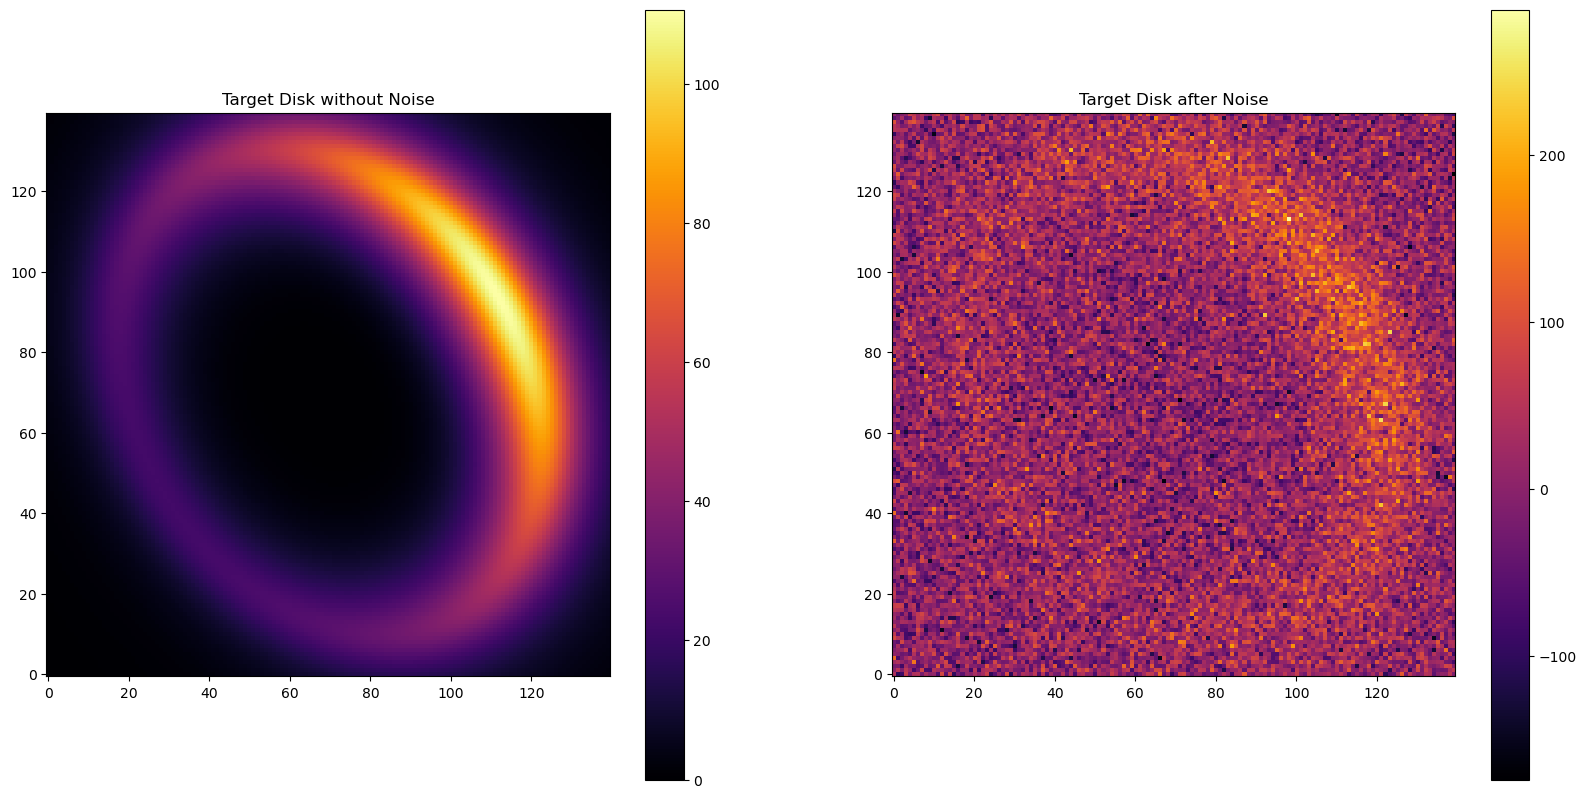

In [4]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image.shape)

# Target Image
target_image = disk_image + noise

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image, origin='lower', cmap='inferno')
axes[0].set_title("Target Disk without Noise")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk after Noise")
plt.colorbar(im,ax=axes[1])

## Fitting the disk parameters

In [5]:
from scipy.optimize import minimize

In [6]:
# Initial Guess

init_params = {}
init_params['inclination'] = 45. #In degrees
init_params['position_angle'] = 45. #In Degrees
init_params['alpha_in'] = 5. #The inner power law
init_params['alpha_out'] = -5. #The outer power law
init_params['flux_scaling'] = 1e6
init_params['sma'] = 25.

init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],
                           init_params['position_angle']])

In [7]:
# Creating error map
def create_circular_err_map(image_shape, radius):
    err_map = jnp.zeros(image_shape)
    center = image_shape[0]/2
    y, x = jnp.ogrid[:image_shape[0], :image_shape[1]]
    distance = jnp.sqrt((x - center) ** 2 + (y - center) ** 2)  
    err_map = jnp.where(distance <= radius, noise_level, err_map)
    return err_map

In [53]:
KNOTS = 6
inc = disk_params['inclination']*jnp.pi/180
inc_bounded_knots = jnp.linspace(0.1+jnp.cos(inc), -0.1+jnp.cos(jnp.pi-inc), KNOTS)

init_knot_xs = inc_bounded_knots
init_spf_params = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(DoubleHenyeyGreenstein_SPF.pack_pars({'g1': 0.5, 'g2': 0.5, 'weight': 0.7}), init_knot_xs)
all_pars_spline = jnp.concatenate([init_disk_params, init_spf_params])

init_image = jax_model_spline(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params, init_spf_params,
                                knots=jnp.linspace(1, -1, KNOTS))

# Creating error map
err_map = jnp.ones(target_image.shape)*noise_level

#err_map = create_circular_err_map(target_image.shape, target_image.shape[0]/2+10)

# Spline spf function (should work for all disk images)
llp_spline = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                                                        disk_params['flux_scaling'], target_image, err_map, knots = inc_bounded_knots)

BOUNDS = [(1, 10), (-1, 10), (10, 80), (0, 180), (0, 180), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

# Using values from previous code block as initial guesses
opt = {'disp':True,'maxiter':4000}
soln_spline = minimize(llp_spline, all_pars_spline, options=opt, method = "Nelder-Mead", )
print(soln_spline)

Optimization terminated successfully.
         Current function value: 86490.554165
         Iterations: 2566
         Function evaluations: 3593
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 86490.5541648461
             x: [ 4.712e+00 -7.685e+00  4.022e+01  3.966e+01  3.040e+01
                  1.335e-01  5.152e-02  3.184e-02  2.100e-02  1.695e-02
                  3.280e-03]
           nit: 2566
          nfev: 3593
 final_simplex: (array([[ 4.712e+00, -7.685e+00, ...,  1.695e-02,
                         3.280e-03],
                       [ 4.712e+00, -7.685e+00, ...,  1.695e-02,
                         3.280e-03],
                       ...,
                       [ 4.712e+00, -7.685e+00, ...,  1.695e-02,
                         3.280e-03],
                       [ 4.712e+00, -7.685e+00, ...,  1.695e-02,
                         3.280e-03]]), array([ 8.649e+04,  8.649e+04,  8.649e+04,  8.649e+04,
                   

Text(0.5, 1.0, 'Target Image')

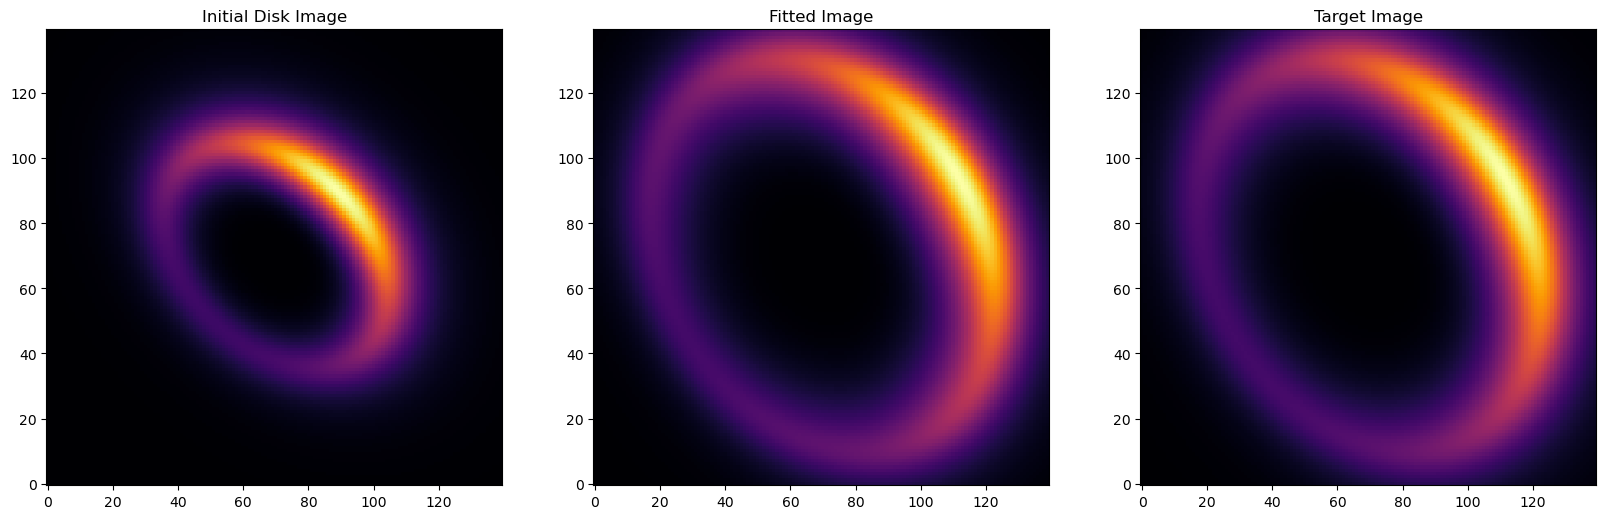

In [54]:
fitted_disk_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                     InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:], knots=inc_bounded_knots),
                                     init_params["flux_scaling"])

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(init_image, origin='lower', cmap='inferno')
axes[0].set_title("Initial Disk Image")

im = axes[1].imshow(fitted_disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Fitted Image")

im = axes[2].imshow(disk_image, origin='lower', cmap='inferno')
axes[2].set_title("Target Image")

In [55]:
fitted_disk_params = soln_spline.x[0:5]

'''
def run_sim(num_sims):
    vals = np.ndarray((KNOTS, num_sims))
    results = np.ndarray(num_sims)

    BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))

    for i in range(0, num_sims):
        array = np.random.uniform(BOUNDS[0], BOUNDS[1])
        ll = log_likelihood_1d_pos_spline(fitted_disk_params, array, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
                                        target_image, err_map)
        vals = np.insert(vals, i, array, axis=1)
        results[i] = ll

    return results

start = datetime.now()
results1 = run_sim(1000)
end = datetime.now()
print(end-start)

start = datetime.now()
results2 = run_sim(10000)
end = datetime.now()
print(end-start)'''

"\ndef run_sim(num_sims):\n    vals = np.ndarray((KNOTS, num_sims))\n    results = np.ndarray(num_sims)\n\n    BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))\n\n    for i in range(0, num_sims):\n        array = np.random.uniform(BOUNDS[0], BOUNDS[1])\n        ll = log_likelihood_1d_pos_spline(fitted_disk_params, array, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],\n                                        target_image, err_map)\n        vals = np.insert(vals, i, array, axis=1)\n        results[i] = ll\n\n    return results\n\nstart = datetime.now()\nresults1 = run_sim(1000)\nend = datetime.now()\nprint(end-start)\n\nstart = datetime.now()\nresults2 = run_sim(10000)\nend = datetime.now()\nprint(end-start)"

In [56]:
'''import matplotlib.patches as mpatches

fig, axes = plt.subplots(1,2, figsize=(20,10))

# Creating legend with color box 
blue_patch = mpatches.Patch(color='skyblue', label='# of results')
red_patch = mpatches.Patch(color='red', label='Optimizer Log-Likelihood: '+str(round(soln_spline.fun, 2)))

axes[0].hist(results1, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("1000 Simulations")
axes[0].vlines(soln_spline.fun, 0, axes[0].get_ylim()[1], color = 'r')
axes[0].legend(handles=[blue_patch, red_patch]) 

axes[1].hist(results2, bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("10000 Simulations")
axes[1].vlines(soln_spline.fun, 0, axes[1].get_ylim()[1], color = 'r')
axes[1].legend(handles=[blue_patch, red_patch]) 

plt.show()'''

'import matplotlib.patches as mpatches\n\nfig, axes = plt.subplots(1,2, figsize=(20,10))\n\n# Creating legend with color box \nblue_patch = mpatches.Patch(color=\'skyblue\', label=\'# of results\')\nred_patch = mpatches.Patch(color=\'red\', label=\'Optimizer Log-Likelihood: \'+str(round(soln_spline.fun, 2)))\n\naxes[0].hist(results1, bins=30, color=\'skyblue\', edgecolor=\'black\')\naxes[0].set_title("1000 Simulations")\naxes[0].vlines(soln_spline.fun, 0, axes[0].get_ylim()[1], color = \'r\')\naxes[0].legend(handles=[blue_patch, red_patch]) \n\naxes[1].hist(results2, bins=30, color=\'skyblue\', edgecolor=\'black\')\naxes[1].set_title("10000 Simulations")\naxes[1].vlines(soln_spline.fun, 0, axes[1].get_ylim()[1], color = \'r\')\naxes[1].legend(handles=[blue_patch, red_patch]) \n\nplt.show()'

## MCMC Simulating the Spline Parameters

In [57]:
%matplotlib inline

from mcmc_model import MCMC_model

plt.rcParams['figure.figsize'] = (20, 10)

In [58]:
#ll = lambda theta: -log_likelihood_1d_pos_spline(fitted_disk_params, theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
#                                        target_image, err_map)

#BOUNDS = np.array((np.zeros(KNOTS), np.ones(KNOTS)))

#mc_model = MCMC_model(ll, BOUNDS)

In [59]:
#sampler, pos, prob, state = mc_model.run(init_spf_params)

In [60]:
#'''
#labels = []
#for i in range(0, KNOTS):
#    labels.append('k'+str(i+1))
#mc_model.show_corner_plot(labels)'''

In [61]:
'''params = mc_model.get_theta_max()
best_fit_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, fitted_disk_params, InterpolatedUnivariateSpline_SPF.pack_pars(params), disk_params['flux_scaling'])

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(best_fit_image, origin='lower', cmap='inferno')
axes[0].set_title("Best Fit Disk")

im = axes[1].imshow(disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")'''

'params = mc_model.get_theta_max()\nbest_fit_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, fitted_disk_params, InterpolatedUnivariateSpline_SPF.pack_pars(params), disk_params[\'flux_scaling\'])\n\nfig, axes = plt.subplots(1,2, figsize=(20,10))\n\nim = axes[0].imshow(best_fit_image, origin=\'lower\', cmap=\'inferno\')\naxes[0].set_title("Best Fit Disk")\n\nim = axes[1].imshow(disk_image, origin=\'lower\', cmap=\'inferno\')\naxes[1].set_title("Target Disk")'

In [62]:
#%timeit ll(mc_model.get_theta_max())

Text(0.5, 1.0, 'Target Image')

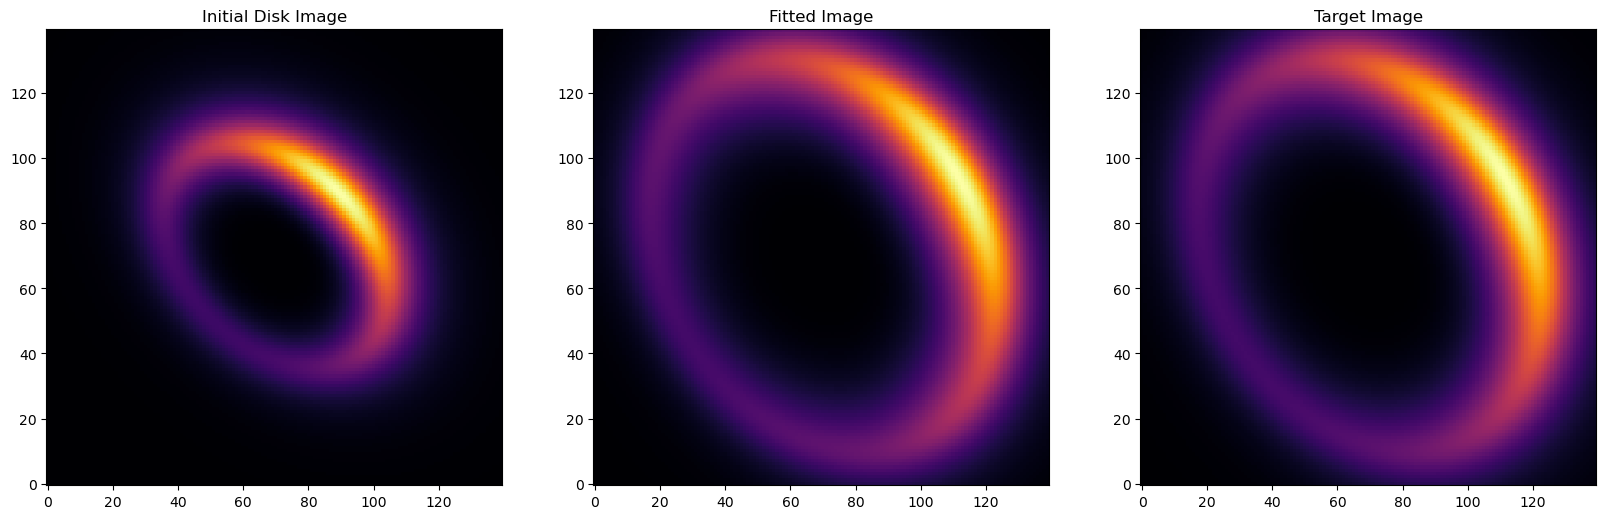

In [63]:
fitted_disk_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, soln_spline.x[0:5],
                                     InterpolatedUnivariateSpline_SPF.pack_pars(soln_spline.x[5:], knots=inc_bounded_knots),
                                     init_params["flux_scaling"])

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(init_image, origin='lower', cmap='inferno')
axes[0].set_title("Initial Disk Image")

im = axes[1].imshow(fitted_disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Fitted Image")

im = axes[2].imshow(disk_image, origin='lower', cmap='inferno')
axes[2].set_title("Target Image")

## MCMC Fitting all the parameters

Running burn-in...
Running production...
0:15:36.843035


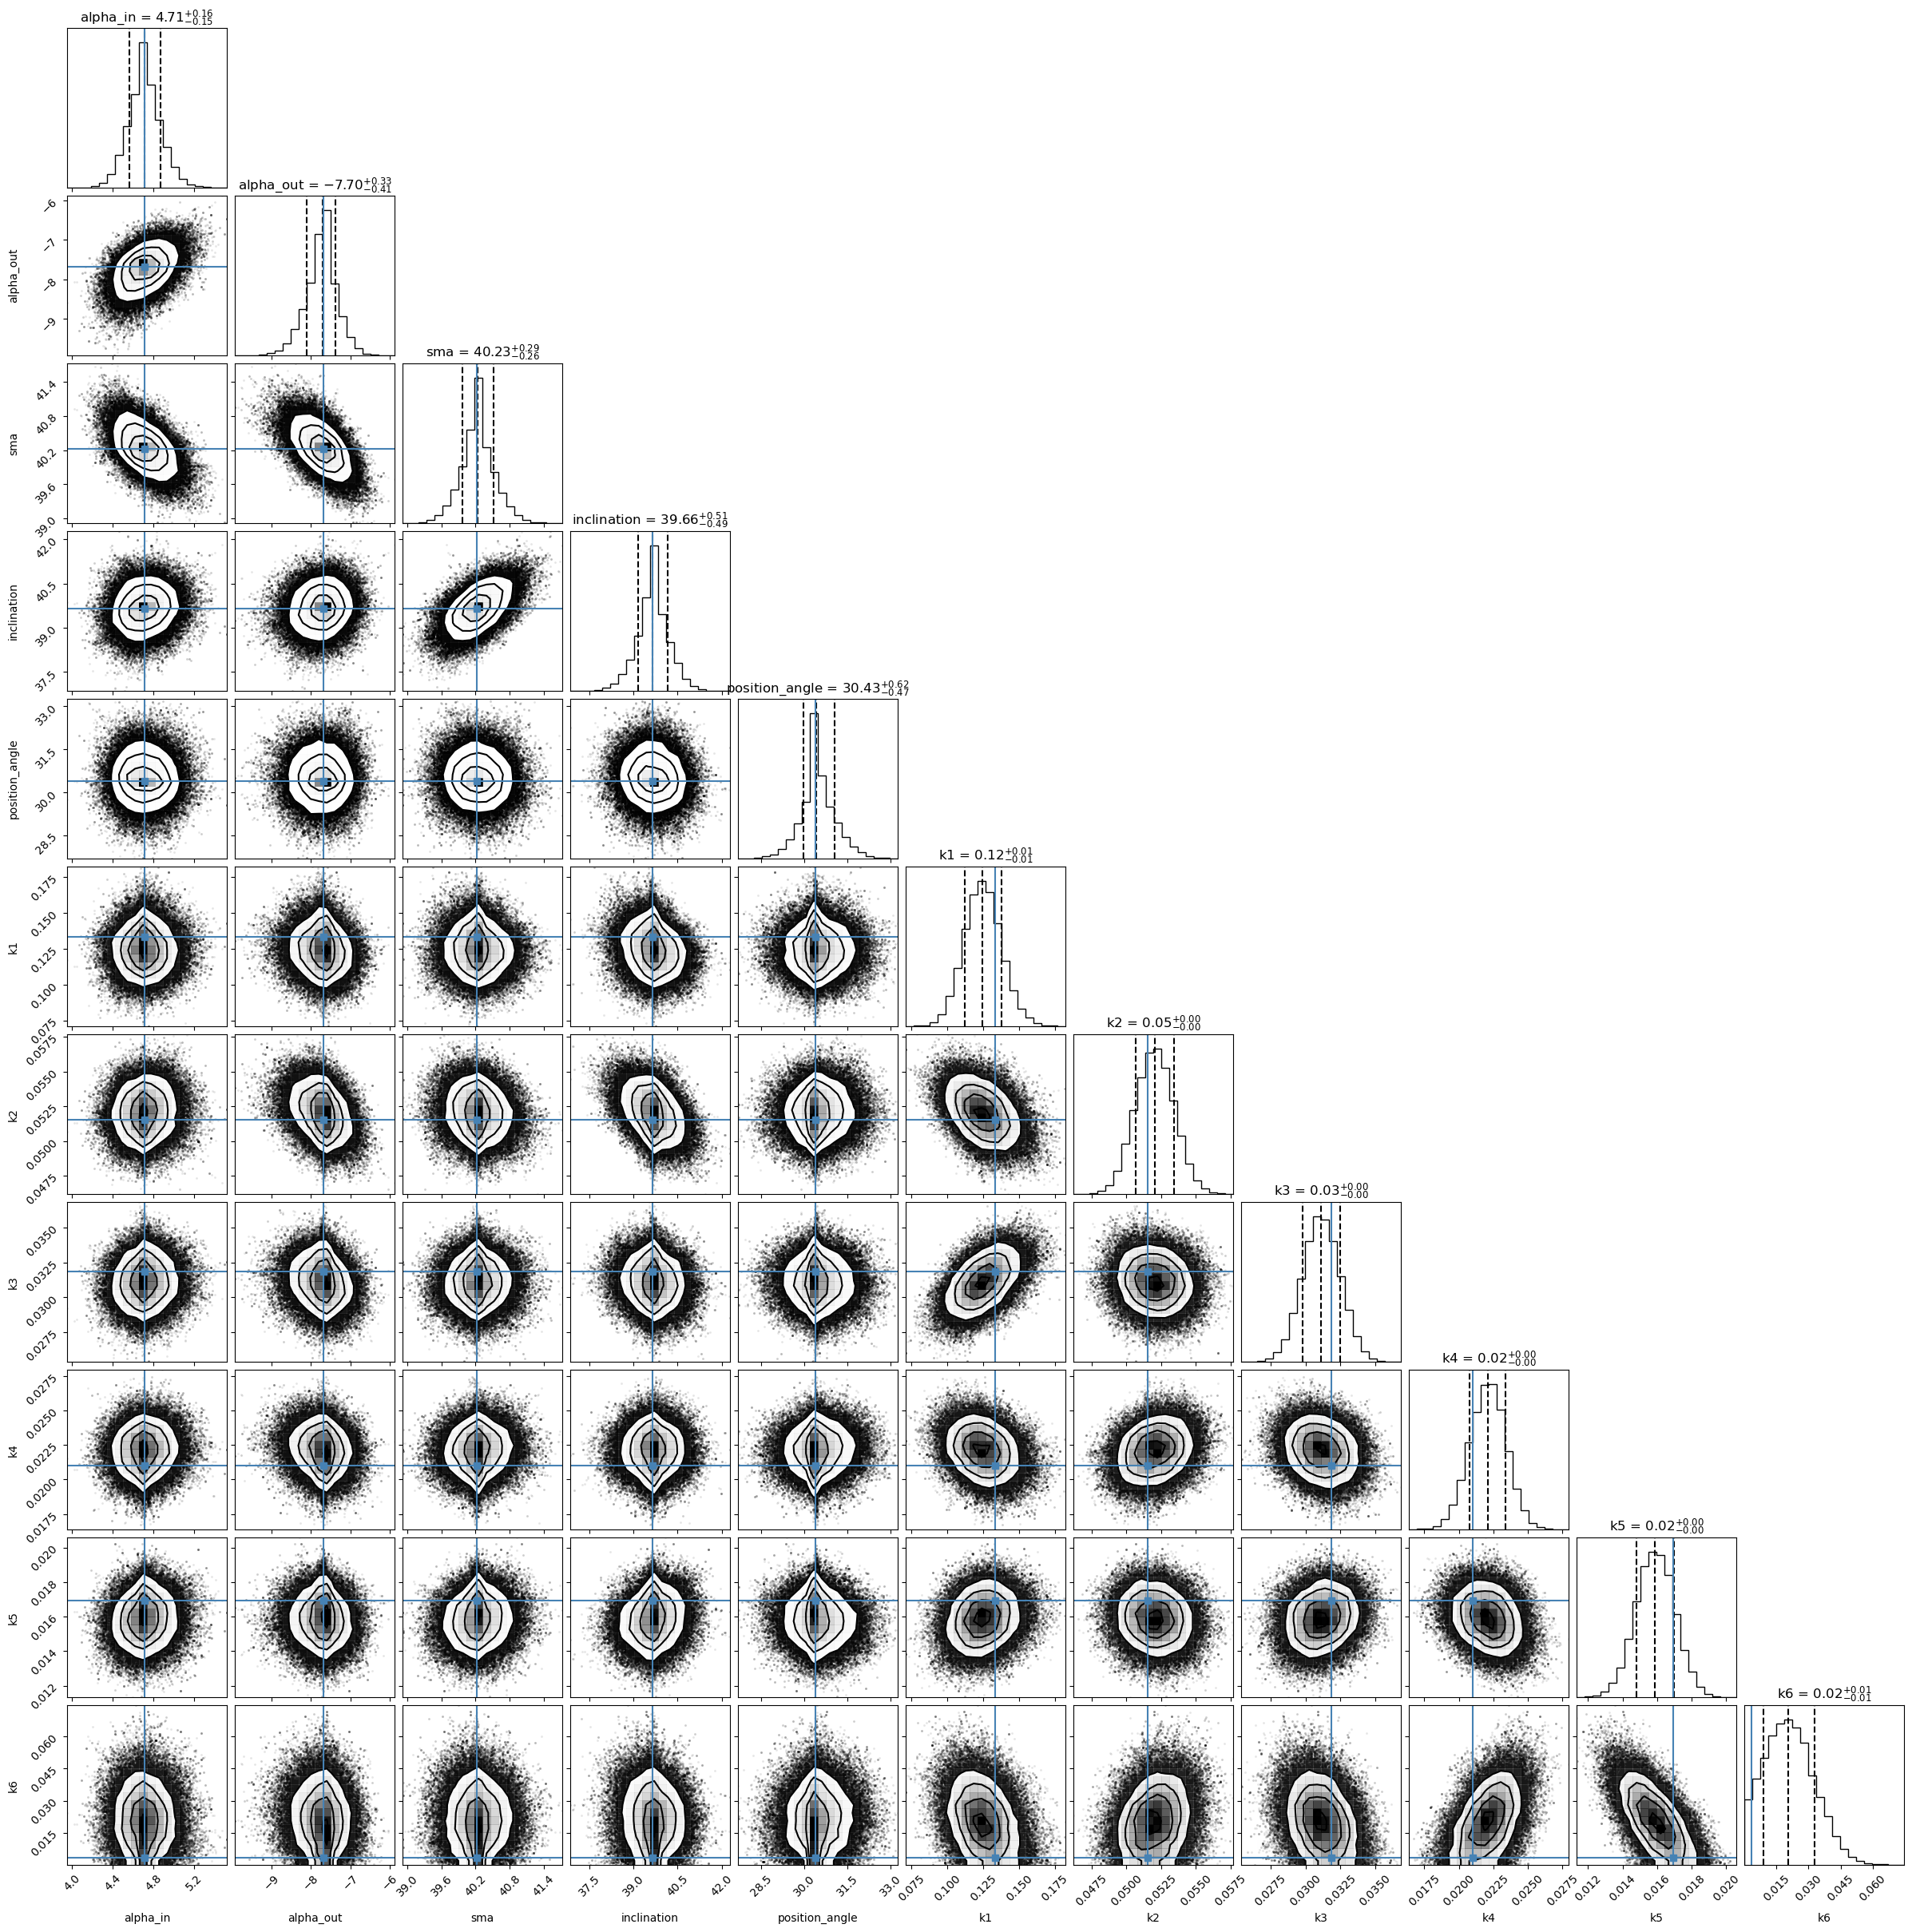

In [64]:
inc = jnp.pi/180*disk_params['inclination']

llap = lambda theta: -log_likelihood_1d_pos_all_pars_spline(theta, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, init_params['flux_scaling'],
                                        target_image, err_map, knots=inc_bounded_knots)

#init_disk_params = jnp.array([init_params['alpha_in'], init_params['alpha_out'], init_params['sma'], init_params['inclination'],
#                           init_params['position_angle']])

DISK_BOUNDS = np.array([np.array([1, -10, 10, 0, 0]), np.array([10, -1, 80, 180, 180])])
SPLINE_BOUNDS = np.array([np.zeros(KNOTS), np.ones(KNOTS)])
BOUNDS = np.array([np.concatenate([DISK_BOUNDS[0], SPLINE_BOUNDS[0]]), np.concatenate([DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])

start = datetime.now()
mc_model = MCMC_model(llap, BOUNDS)
mc_model.run(soln_spline.x, nconst = 1e-7)
labels = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle']
for i in range(0, KNOTS):
    labels.append('k'+str(i+1))
mc_model.show_corner_plot(labels, truths=soln_spline.x)
end = datetime.now()
print(end-start)

[ 4.71033869e+00 -7.66386860e+00  4.02086751e+01  3.96274157e+01
  3.04233438e+01  1.23959675e-01  5.19902585e-02  3.12330868e-02
  2.22335265e-02  1.63765975e-02  1.75157743e-02]


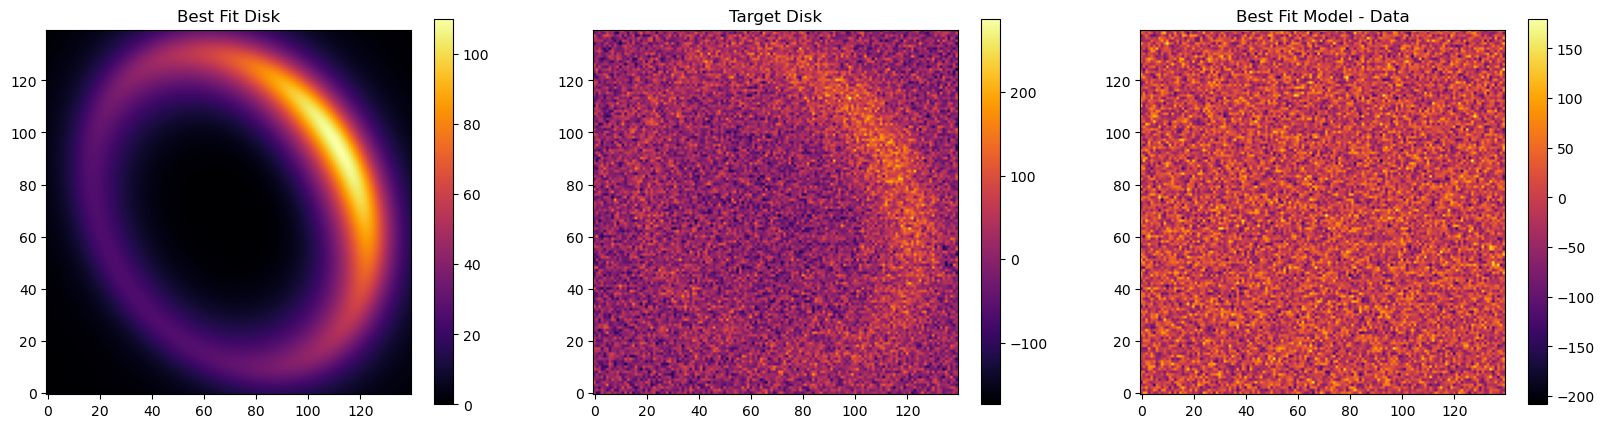

In [65]:
params = mc_model.get_theta_max()
print(params)
best_fit_image = jax_model_all_1d(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, params[0:5],
                                InterpolatedUnivariateSpline_SPF.pack_pars(params[5:], knots=inc_bounded_knots), disk_params['flux_scaling'])

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(best_fit_image, origin='lower', cmap='inferno')
axes[0].set_title("Best Fit Disk")
plt.colorbar(im,ax=axes[0], shrink=0.5)

im = axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")
plt.colorbar(im,ax=axes[1], shrink=0.5)

im = axes[2].imshow(best_fit_image-target_image, origin='lower', cmap='inferno')
axes[2].set_title("Best Fit Model - Data")
plt.colorbar(im,ax=axes[2], shrink=0.5)

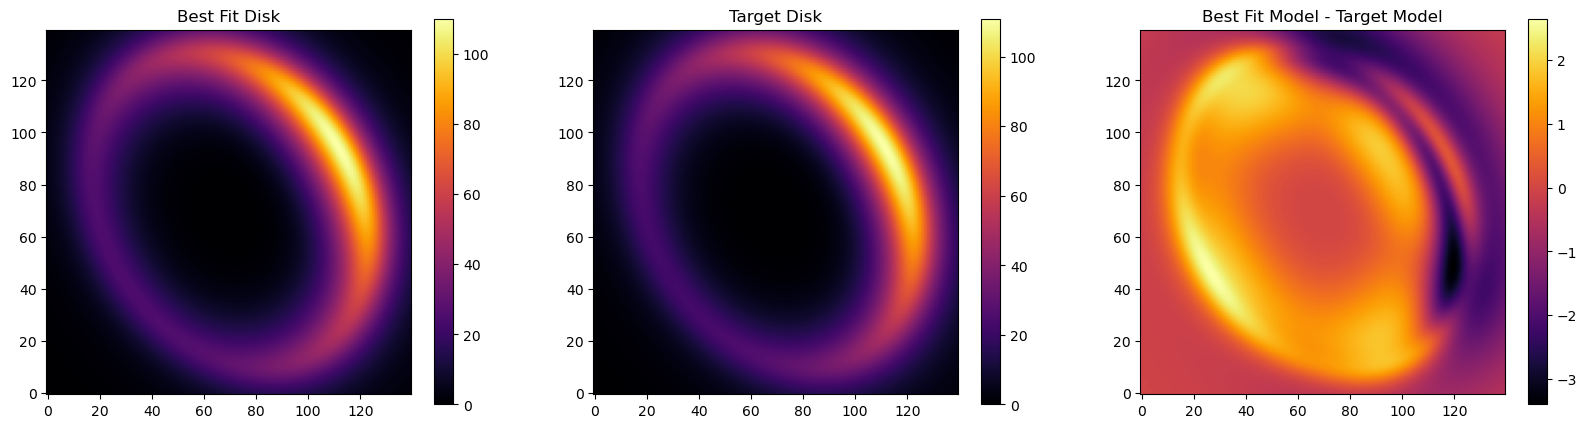

In [66]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(best_fit_image, origin='lower', cmap='inferno')
axes[0].set_title("Best Fit Disk")
#im.set_clim(0, 120)
plt.colorbar(im,ax=axes[0], shrink=0.5)

im = axes[1].imshow(disk_image, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk")
#im.set_clim(0, 120)
plt.colorbar(im,ax=axes[1], shrink=0.5)

im = axes[2].imshow(best_fit_image-disk_image, origin='lower', cmap='inferno')
axes[2].set_title("Best Fit Model - Target Model")
#im.set_clim(0, 120)
plt.colorbar(im,ax=axes[2], shrink=0.5)

IndexError: index 11 is out of bounds for axis 2 with size 11

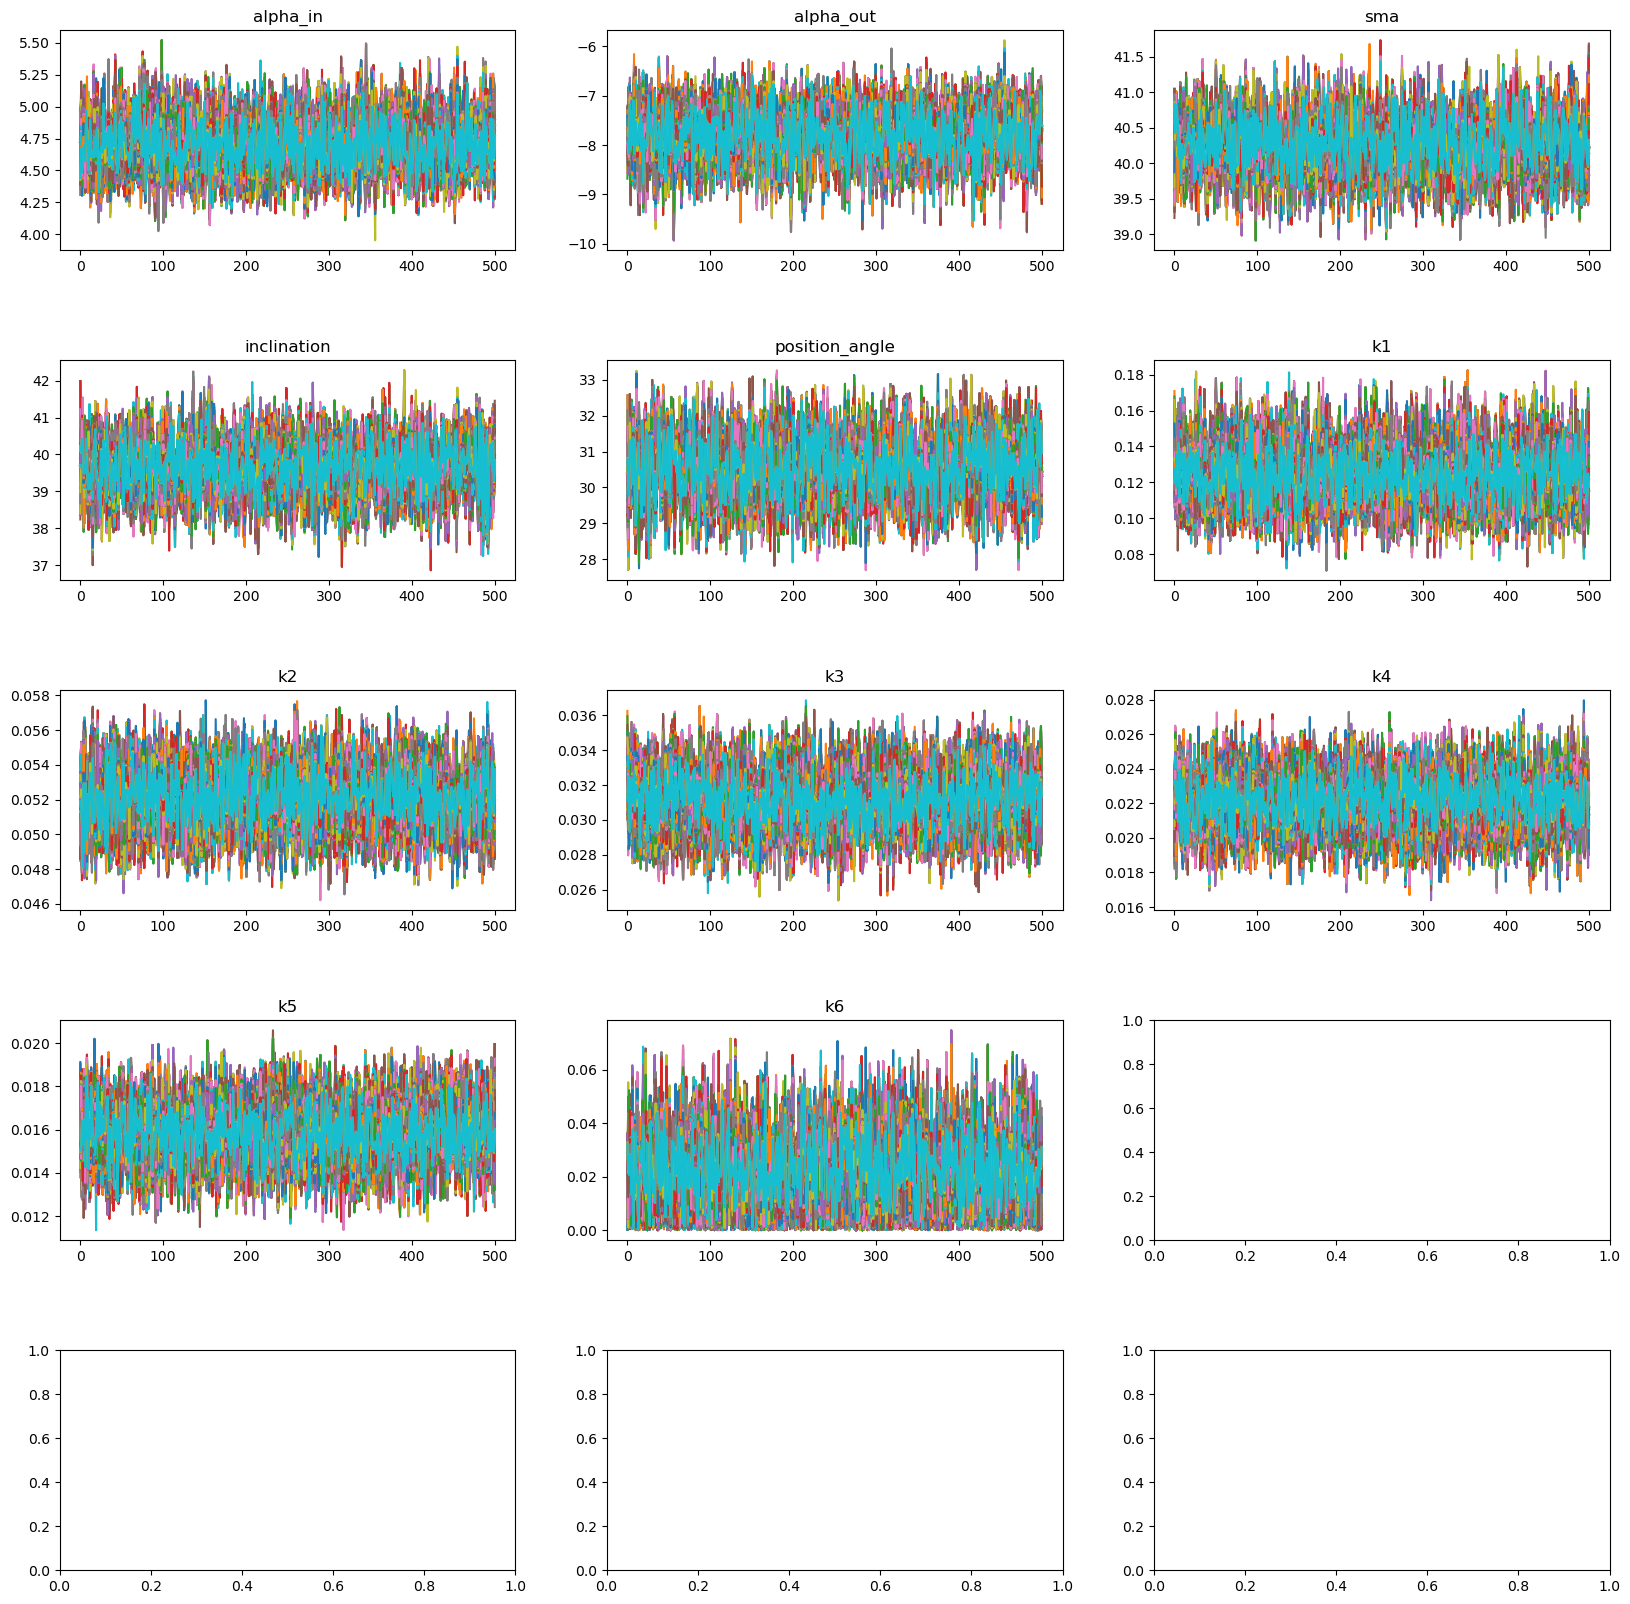

In [67]:
fig, axes = plt.subplots(5,3, figsize=(20,20))
fig.subplots_adjust(hspace=0.5)

for i in range(0, 5):
    for j in range(0, 3):
        axes[i][j].plot(np.linspace(0, 500, 500), mc_model.sampler.get_chain()[:, :, 3*i+j].T)
        axes[i][j].set_title(labels[3*i+j])

In [68]:
import matplotlib.patches as mpatches

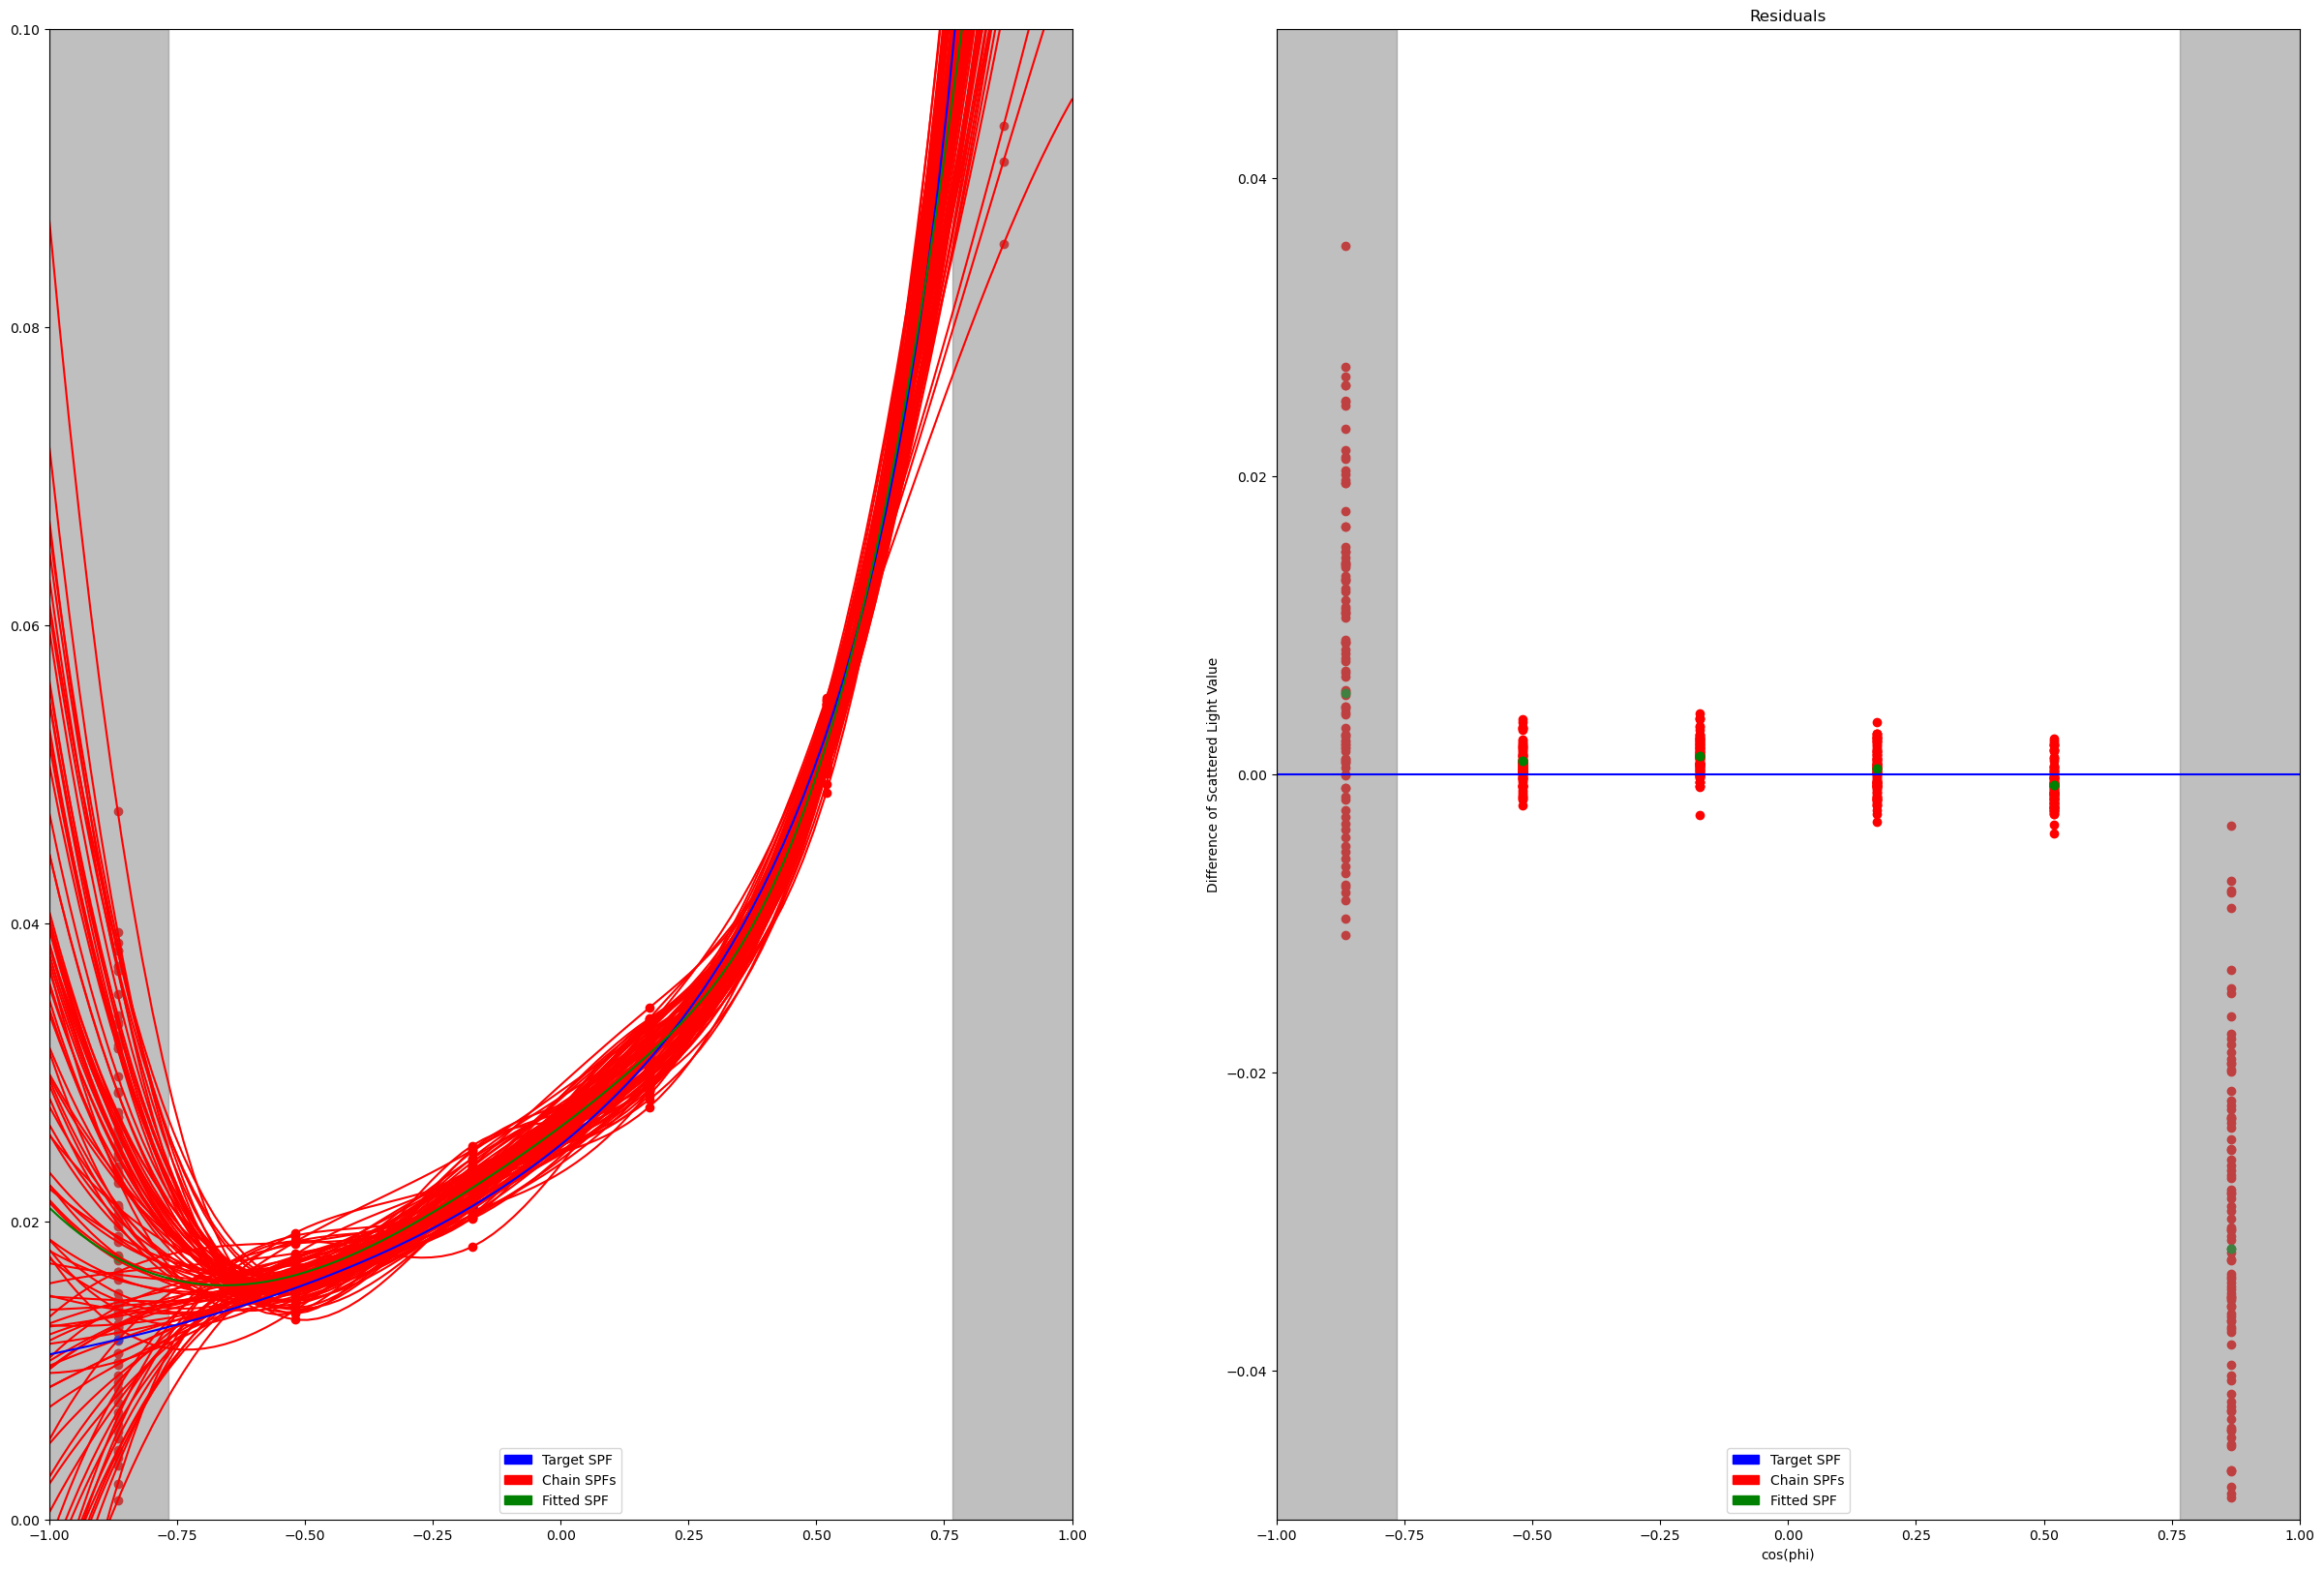

: 

In [69]:
flat_samples = mc_model.sampler.flatchain

tar_spf = DoubleHenyeyGreenstein_SPF.pack_pars(spf_params)
tar_xks = inc_bounded_knots
tar_yks = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_xks)
tar_xs = jnp.linspace(1, -1, 100)
tar_ys = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_xs)

fig, axes = plt.subplots(1,2, figsize=(30,20))
# Creating legend with color box 
blue_patch = mpatches.Patch(color='blue', label='Target SPF')
red_patch = mpatches.Patch(color='red', label='Chain SPFs')
green_patch = mpatches.Patch(color='green', label='Fitted SPF')


inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    spline_model = InterpolatedUnivariateSpline_SPF.init(sample[5:], knots=inc_bounded_knots)
    fin_kxs = inc_bounded_knots
    fin_kys = spline_model(fin_kxs)
    fin_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
    fin_ys = spline_model(fin_xs)
    axes[0].scatter(fin_kxs, fin_kys, color = 'r')
    axes[0].plot(fin_xs, fin_ys, color = 'r')
    axes[1].scatter(fin_kxs, fin_kys-tar_yks, color = 'r')

# Target Values
axes[0].plot(tar_xs, tar_ys, color = 'b')
axes[0].scatter(tar_xks, tar_yks, color = 'b')

# Fitted Values
spline_model = InterpolatedUnivariateSpline_SPF.init(mc_model.get_theta_max()[5:], knots=inc_bounded_knots)
fit_xks = inc_bounded_knots
fit_yks = spline_model(fit_xks)
fit_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
fit_ys = spline_model(fit_xs)
axes[0].scatter(fit_xks, fit_yks, color = 'g')
axes[0].plot(fit_xs, fit_ys, color = 'g')
axes[1].scatter(fit_xks, fit_yks-tar_yks, color = 'g')
axes[1].scatter(fit_xks, fit_yks-tar_yks, color = 'g')

axes[1].set_title("Plots")
axes[0].axvspan(-1, np.cos((180-disk_params['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[0].axvspan(np.cos(disk_params['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(0, 0.1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Scattered Light Value")

axes[1].set_title("Residuals")
axes[1].axvspan(-1, np.cos((180-disk_params['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[1].axvspan(np.cos(disk_params['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-0.05, 0.05)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Difference of Scattered Light Value")
axes[1].hlines(0, -1, 1, color = 'b')

axes[0].legend(handles=[blue_patch, red_patch, green_patch])
axes[1].legend(handles=[blue_patch, red_patch, green_patch])

plt.show()